## **Import Libraries, Data and Theme set up**

In [2]:
# General purpose packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import os

# Data processing
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

# Machine learning models
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Natural Language Processing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# Import functions from other files
from cleaning_tweets import *
from find_country import *

# Set seed for reproducibility
seed = 42

In [3]:
# Define your color palette
colors_palette = list(mcolors.CSS4_COLORS.keys())

# Set the color palette
sns.set_palette(sns.color_palette(colors_palette))

# Customized theme settings
plt.rcParams.update({
    'figure.facecolor': '#ffffff',
    'axes.facecolor': '#ffffff',
    'axes.edgecolor': '#333333',
    'grid.color': '#ffffff',
    'text.color': '#333333',
    'font.family': 'Dubai',
    'font.size': 20,
    'axes.titleweight': 'bold',
    'axes.titlesize': 30,
    'axes.titlepad': 20,
    'axes.labelsize': 10,
    'axes.labelcolor': '#333333',
    'xtick.color': '#333333',
    'ytick.color': '#333333',
    'legend.facecolor': '#fafafa',
    'legend.edgecolor': '#333333',
    'legend.frameon': True,
    'legend.title_fontsize': 10,
    'legend.fontsize': 15,
    'legend.borderpad': 0.5,
    'legend.borderaxespad': 0.5,
    'legend.loc': 'best',
    'axes.grid': True,
    'grid.linestyle': '-',
    'grid.linewidth': 0.2,
    'grid.alpha': 0.7
})

In [5]:
# Load the COVID-19 data
data = pd.read_csv("covid19 dataset/covid-19-all.csv", 
                   dtype={"Country/Region": str,
                          "Province/State": str,
                          "Latitude": float,
                          "Longitude": float,
                          "Confirmed": float,
                          "Recovered": float,
                          "Deaths": float},
                   parse_dates=["Date"])

# Rename columns
tweets_df = pd.read_csv("tweets dataset/Coronavirus tweets NLP - Text Classification/tweets_train.csv", encoding="ISO-8859-1")

## **Missing Data**

This section focuses on identifying, analyzing, and handling missing values in a dataset.

#### Data DF

In [6]:
# Plot missing values for both numeric and categorical variables
missing_values = data.isnull().sum()

In [7]:
# Separate numeric and categorical columns
categorical_cols = data.select_dtypes(exclude='number').columns
numeric_cols = data.select_dtypes(include='number').columns

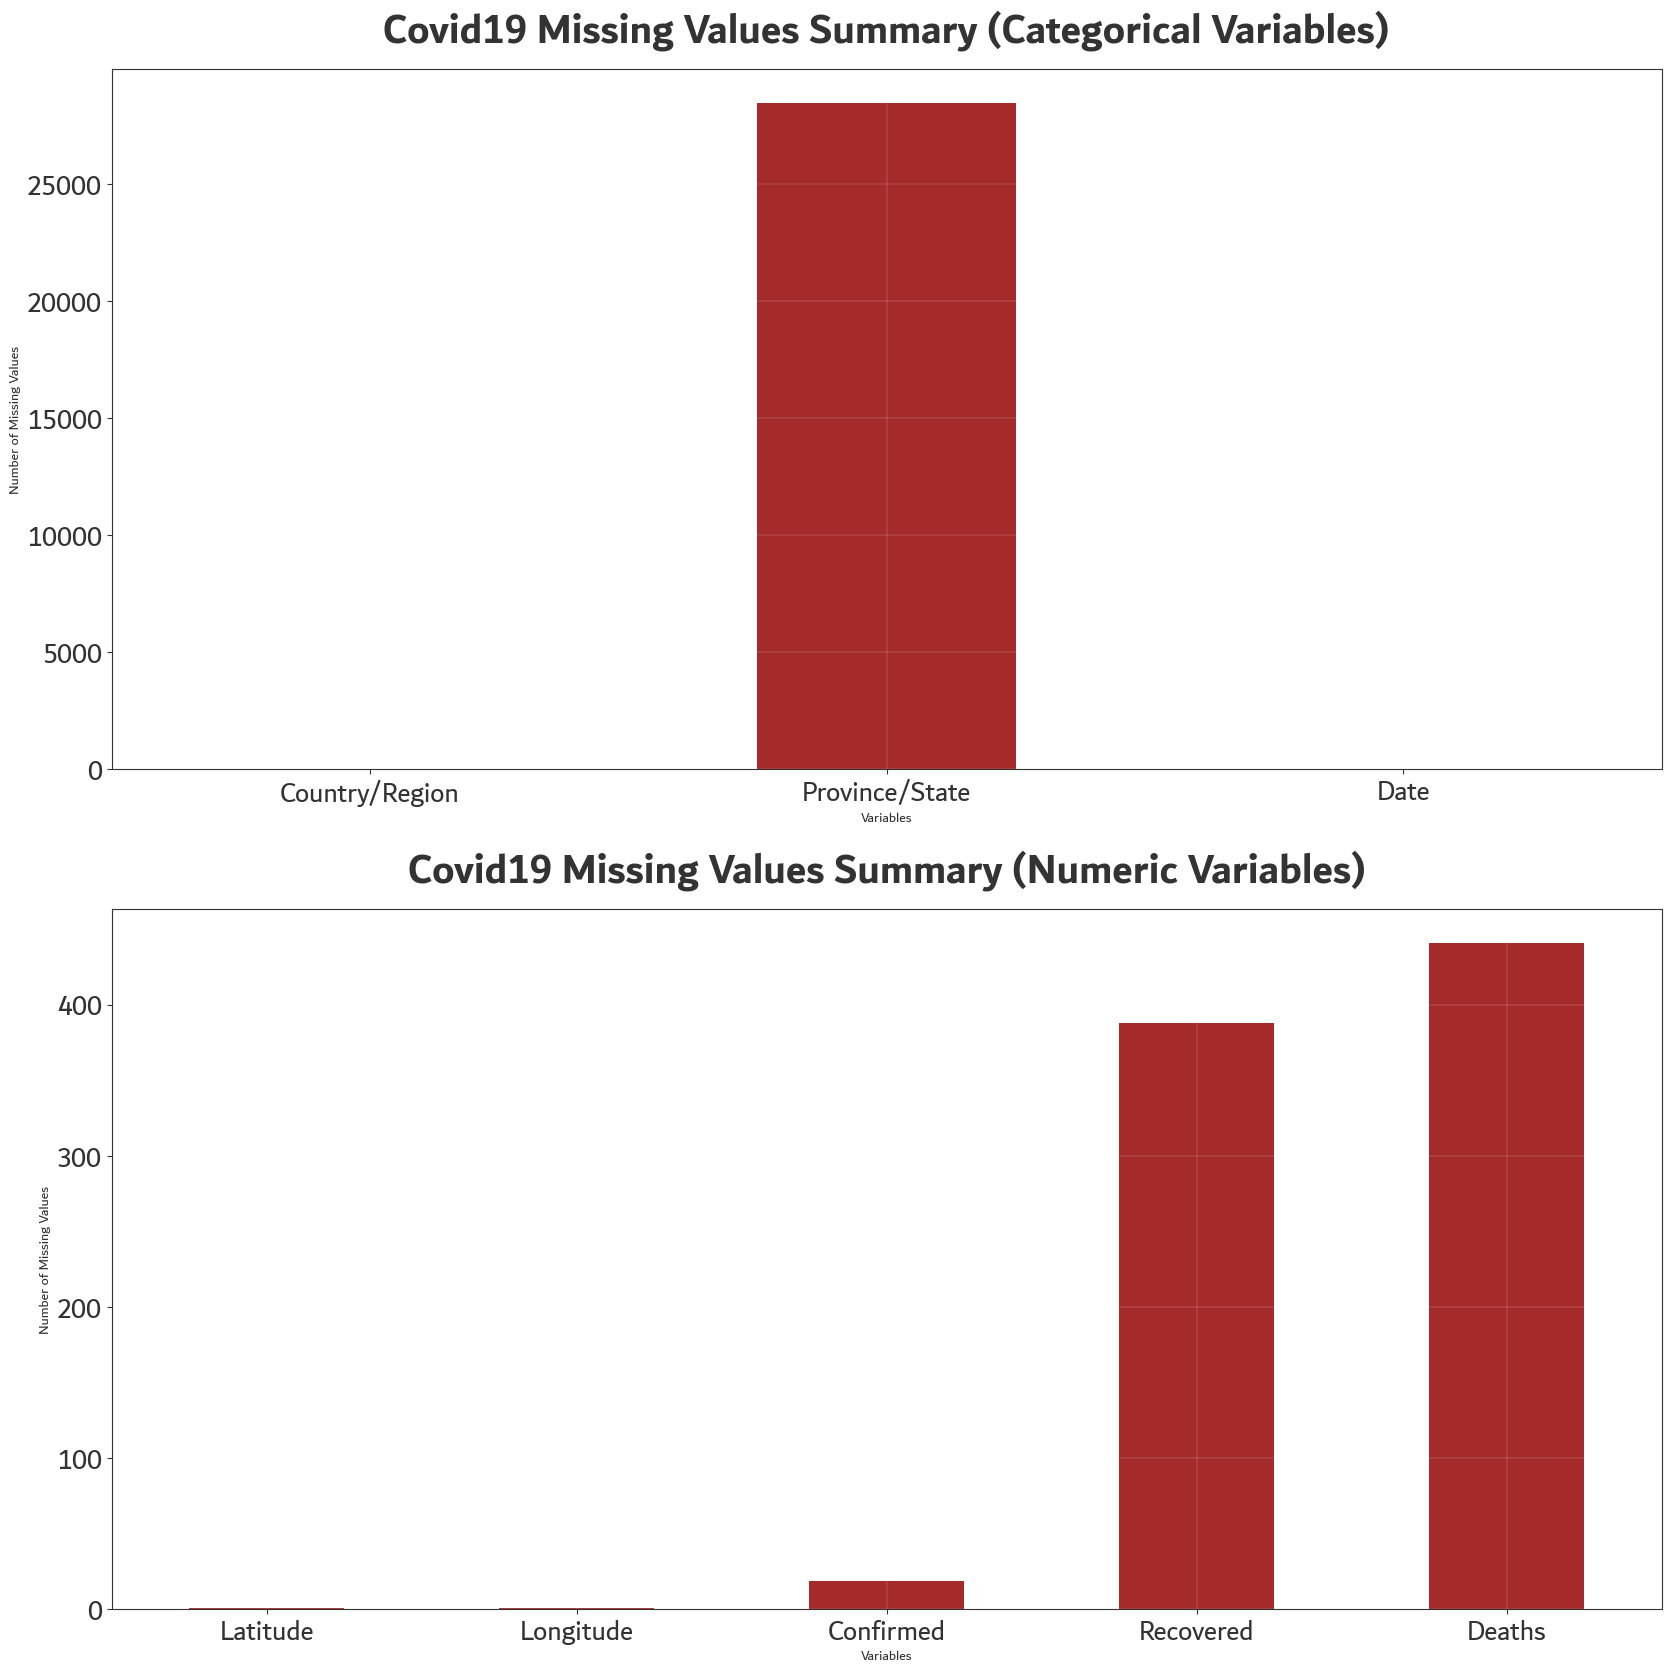

In [8]:
fig, axes = plt.subplots(nrows=2, figsize=(20, 20))

# Plot missing values for categorical columns
missing_values[categorical_cols].plot(kind='bar', color=colors_palette[11], ax=axes[0])
axes[0].set_title('Covid19 Missing Values Summary (Categorical Variables)')
axes[0].set_xlabel('Variables')
axes[0].set_ylabel('Number of Missing Values')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Plot missing values for numeric columns
missing_values[numeric_cols].plot(kind='bar', color=colors_palette[11], ax=axes[1])
axes[1].set_title('Covid19 Missing Values Summary (Numeric Variables)')
axes[1].set_xlabel('Variables')
axes[1].set_ylabel('Number of Missing Values')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# plt.tight_layout()
plt.show()

The numerous missing values in the Province/State column are not an issue, as only the Country/Region column will be used for analysis.

To address the missing values in the Confirmed, Recovered and Deaths columns, those rows will be removed.

In [9]:
# Summary statistics
print(data.describe())

            Latitude      Longitude      Confirmed     Recovered  \
count  515799.000000  515799.000000  515781.000000  5.154120e+05   
mean       36.144712     -74.610614    2226.450247  1.139407e+03   
std        12.100733      50.562405   14470.824083  1.593774e+04   
min       -52.368000    -174.159600       0.000000  0.000000e+00   
25%        33.581382     -96.266882      10.000000  0.000000e+00   
50%        37.919235     -87.159187      63.000000  0.000000e+00   
75%        41.829727     -79.121679     394.000000  0.000000e+00   
max        72.000000     178.065000  674455.000000  1.774648e+06   

              Deaths  
count  515359.000000  
mean      107.129096  
std      1016.943643  
min         0.000000  
25%         0.000000  
50%         1.000000  
75%        10.000000  
max     42072.000000  


In [10]:
# Drop rows with missing values in specified columns
data = data.dropna(subset=["Confirmed", "Recovered", "Deaths"])
data.reset_index(drop=True, inplace=True)

print(data.describe())

            Latitude      Longitude      Confirmed     Recovered  \
count  515335.000000  515335.000000  515336.000000  5.153360e+05   
mean       36.151301     -74.755857    2228.346349  1.139575e+03   
std        12.094260      50.310808   14476.926591  1.593891e+04   
min       -52.368000    -174.159600       0.000000  0.000000e+00   
25%        33.588398     -96.266882      10.000000  0.000000e+00   
50%        37.924657     -87.178784      63.000000  0.000000e+00   
75%        41.835700     -79.145487     395.000000  0.000000e+00   
max        72.000000     178.065000  674455.000000  1.774648e+06   

              Deaths  
count  515336.000000  
mean      107.133829  
std      1016.966090  
min         0.000000  
25%         0.000000  
50%         1.000000  
75%        10.000000  
max     42072.000000  


#### Tweets DF

In [11]:
# Plot missing values for variables
missing_values = tweets_df.isnull().sum()

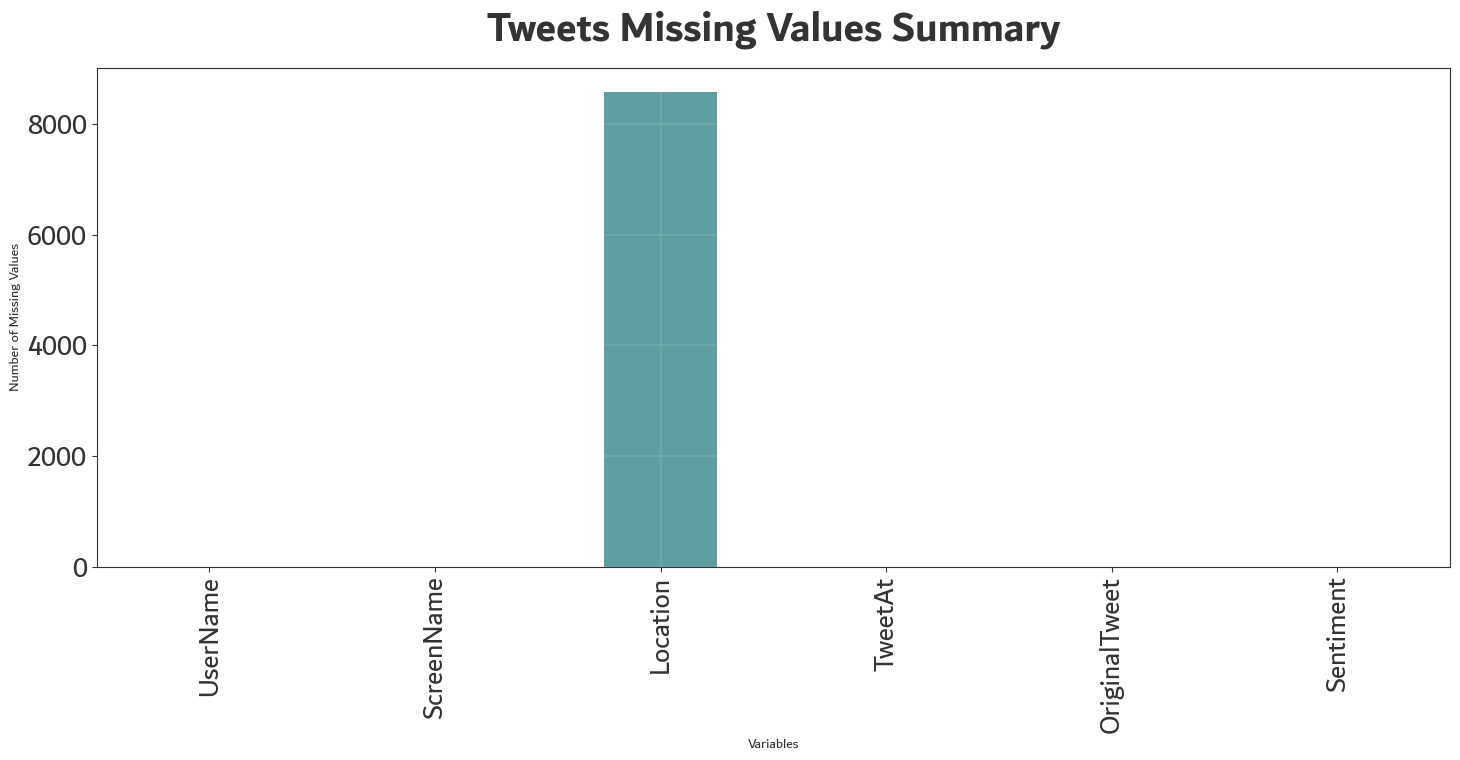

In [12]:
missing_values.plot(kind='bar', color=colors_palette[13], figsize=(15, 8))
plt.title('Tweets Missing Values Summary')
plt.xlabel('Variables')
plt.ylabel('Number of Missing Values')
plt.tight_layout()
plt.show()

In [13]:
# print total of tweets with missing values for location
print(f"Total missing values for location: {missing_values['Location']}")

# print total number of tweets
print(f"Total number of tweets: {tweets_df.shape[0]}")

# print the percentage on total tweets of those with missing values for location
print(f"Percentage of missing values for location: {missing_values['Location']/tweets_df.shape[0]*100:.2f}%")

Total missing values for location: 8590
Total number of tweets: 41157
Percentage of missing values for location: 20.87%


Although the 'Location' column is necessary for later analysis, we will not remove all tweets with missing values in this column because they make up more than 20% of the total dataset.

## **COVID Cases Situation**

Before moving to Sentiment Analysis, we first examine the global trend of COVID-19 cases. By doing so, we aim to establish a comprehensive understanding of how the pandemic has spread across different regions.

This analysis will then serve as a basis for comparing the geographical distribution of COVID-19 cases with the locations mentioned in the tweets.

This comparison is crucial for identifying any correlations between the sentiment expressed in the tweets and the actual pandemic situation in those regions.


#### Reported Cases

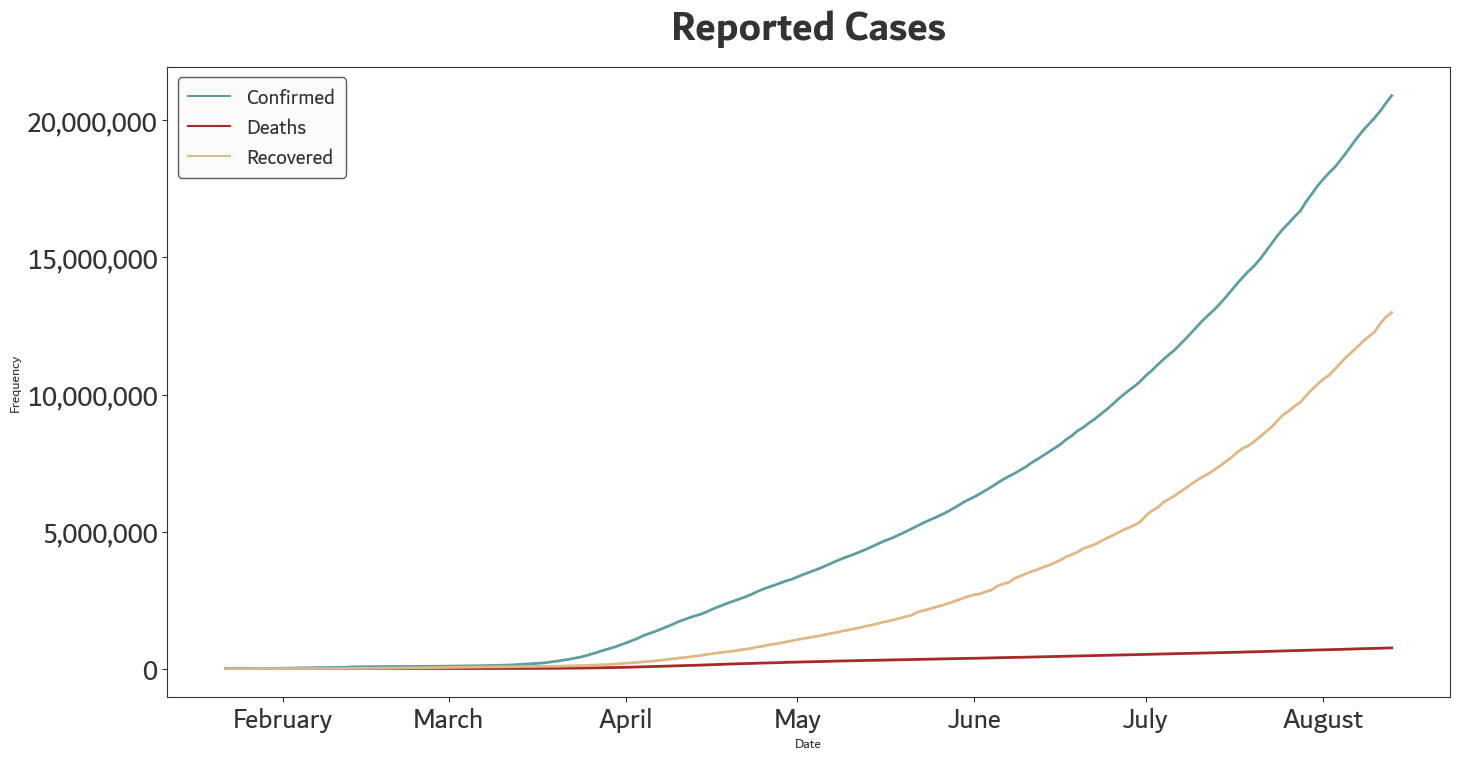

In [14]:
# Select relevant columns and gather data
data_gathered = data[['Date', 'Confirmed', 'Recovered', 'Deaths']].melt(id_vars=['Date'], var_name='group_var', value_name='Cases')
data_summarized = data_gathered.groupby(['Date', 'group_var']).sum().reset_index()

# Plotting
plt.figure(figsize=(15, 8))
sns.lineplot(data=data_summarized, x='Date', y='Cases', hue='group_var', palette=[colors_palette[13], colors_palette[11], colors_palette[12]], linewidth=2)

# Formatting
plt.title('Reported Cases')
# plt.suptitle('Feb 2020 - Aug 2020')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))  # Format y-axis labels with commas
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%B"))  # Format x-axis labels as month-year
plt.xticks()
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

The blue line shows a steep and continuous upward trend, indicating a significant increase in the number of confirmed COVID-19 cases over the period. This rapid rise underscores the widespread transmission of the virus globally during these months.

Similarly, the yellow line, representing recovered cases, also shows an upward trend, though at a slower rate compared to confirmed cases. The growing number of recoveries reflects the efforts of healthcare systems to treat and manage COVID-19 patients effectively.

On the other hand, the red line, indicating the number of deaths, rises at a much slower pace compared to the other two variables. Despite its slower ascent, it highlights the severe impact of the pandemic, with a significant number of fatalities.

#### Countries Cases Type

In this section, we group the data by country to sum the confirmed COVID-19 cases for each country.

We then add the corresponding latitude and longitude for each country, clean the data by removing missing values and duplicates, and create a choropleth map to visualize the confirmed cases by country using Plotly.

This process is repeated for the recovered cases and deaths to provide a comprehensive view of the pandemic's impact across different regions.

In [15]:
# Group by country and sum the confirmed cases
confirmed_cases = data.groupby('Country/Region')['Confirmed'].sum().reset_index()
confirmed_cases = confirmed_cases.merge(data[['Country/Region', 'Latitude', 'Longitude']], on='Country/Region', how='left')
confirmed_cases = confirmed_cases.dropna(subset=['Latitude', 'Longitude'])
confirmed_cases.reset_index(drop=True, inplace=True)
confirmed_cases = confirmed_cases.drop_duplicates(subset='Country/Region', keep='first')

In [16]:
import plotly.express as px

fig = px.choropleth(
    confirmed_cases,
    locations='Country/Region',
    locationmode='country names',
    color='Confirmed',
    hover_name='Country/Region',
    color_continuous_scale='Viridis',
    title='Confirmed COVID-19 Cases by Country',
    labels={'Confirmed': 'Confirmed Cases'}
)

fig.update_layout(margin=dict(l=3, r=3, b=20, t=50), width=1200)
fig.show()


In [17]:
# top 5 countries with confirmed cases
top_5_confirmed_countries = confirmed_cases.sort_values(by='Confirmed', ascending=False).head(5)
print(top_5_confirmed_countries)

      Country/Region    Confirmed   Latitude  Longitude
70111             US  306057522.0  41.878100 -87.629800
5002          Brazil  138132156.0 -10.574100 -47.864500
31486          India   74457288.0  23.746783  78.962880
55220         Russia   60106783.0  54.729304  47.084943
64328          Spain   32717583.0  40.416800  -3.097700


In [18]:
# Group by country and sum the recovered cases
recovered_cases = data.groupby('Country/Region')['Recovered'].sum().reset_index()
recovered_cases = recovered_cases.merge(data[['Country/Region', 'Latitude', 'Longitude']], on='Country/Region', how='left')
recovered_cases = recovered_cases.dropna(subset=['Latitude', 'Longitude'])
recovered_cases.reset_index(drop=True, inplace=True)
recovered_cases = recovered_cases.drop_duplicates(subset='Country/Region', keep='first')

In [19]:
# create a cloropleth map using px.choropleth

fig = px.choropleth(recovered_cases, locations='Country/Region', locationmode='country names',
                    color='Recovered', hover_name='Country/Region',
                    color_continuous_scale='Viridis',
                    title='Recovered COVID-19 Cases by Country',
                    labels={'Recovered': 'Recovered Cases'}
                    )
                    
fig.update_layout(margin=dict(l=3, r=3, b=20, t=50), width=1200)

fig.show()

In [20]:
# top 5 countries with recovered cases
top_5_recovered_countries = recovered_cases.sort_values(by='Recovered', ascending=False).head(5)
print(top_5_recovered_countries)

      Country/Region   Recovered   Latitude  Longitude
5002          Brazil  91979924.0 -10.574100 -47.864500
70111             US  82937565.0  41.878100 -87.629800
31486          India  46548670.0  23.746783  78.962880
55220         Russia  36450323.0  54.729304  47.084943
28038        Germany  20420361.0  51.433200   9.993700


In [21]:
# Group by country and sum the death
deaths_cases = data.groupby('Country/Region')['Deaths'].sum().reset_index()
deaths_cases = deaths_cases.merge(data[['Country/Region', 'Latitude', 'Longitude']], on='Country/Region', how='left')
deaths_cases = deaths_cases.dropna(subset=['Latitude', 'Longitude'])
deaths_cases.reset_index(drop=True, inplace=True)
deaths_cases = deaths_cases.drop_duplicates(subset='Country/Region', keep='first')


In [22]:
fig = px.choropleth(deaths_cases, locations='Country/Region', locationmode='country names',
                    color='Deaths', hover_name='Country/Region',
                    color_continuous_scale='Viridis',
                    title='COVID-19 Deaths by Country',
                    labels={'Deaths': 'Deaths'}
                    )

fig.update_layout(margin=dict(l=3, r=3, b=20, t=50), width=1200)

fig.show()

In [23]:
# print top 5 countries with deaths
top_5_deaths_countries = deaths_cases.sort_values(by='Deaths', ascending=False).head(5)
print(top_5_deaths_countries)

        Country/Region      Deaths  Latitude  Longitude
70111               US  13566303.0  41.87810 -87.629800
5002            Brazil   5589911.0 -10.57410 -47.864500
511908  United Kingdom   4718540.0  55.00000  -3.000000
34831            Italy   4305725.0  43.61676  12.388247
25857           France   3563524.0  14.64150 -56.315900


The data reveals significant insights into the global impact of the COVID-19 pandemic, particularly highlighting the United States, Brazil, and India as the most affected countries in terms of confirmed cases.

The United States not only leads in confirmed cases but also shows the highest number of deaths, underscoring the severe toll the pandemic has taken on the country. Brazil, while second in confirmed cases, shows a remarkably high number of recoveries, indicating substantial efforts in patient treatment and management.

## **Tweets Deep Dive**

First, let's observe the total number of tweets for each day, from the minimum date to the maximum date present in the dataset.

In [24]:
tweets_df['TweetAt'] = pd.to_datetime(tweets_df['TweetAt'])

C:\Users\tomma\AppData\Local\Temp\ipykernel_15540\3925010627.py:1: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



In [25]:
tweets_per_day = tweets_df['TweetAt'].dt.date.value_counts().reset_index()
tweets_per_day.columns = ['Date', 'Tweets']
tweets_per_day = tweets_per_day.sort_values(by='Date')

# add other days for a total of 365, where there are no tweets with 0
all_dates = pd.date_range(start=tweets_per_day['Date'].min(), end=tweets_per_day['Date'].max())
all_dates = pd.DataFrame(all_dates, columns=['Date'])
all_dates['Date'] = all_dates['Date'].dt.date

# merge the two dataframes
tweets_per_day = all_dates.merge(tweets_per_day, on='Date', how='left')
tweets_per_day = tweets_per_day.fillna(0)

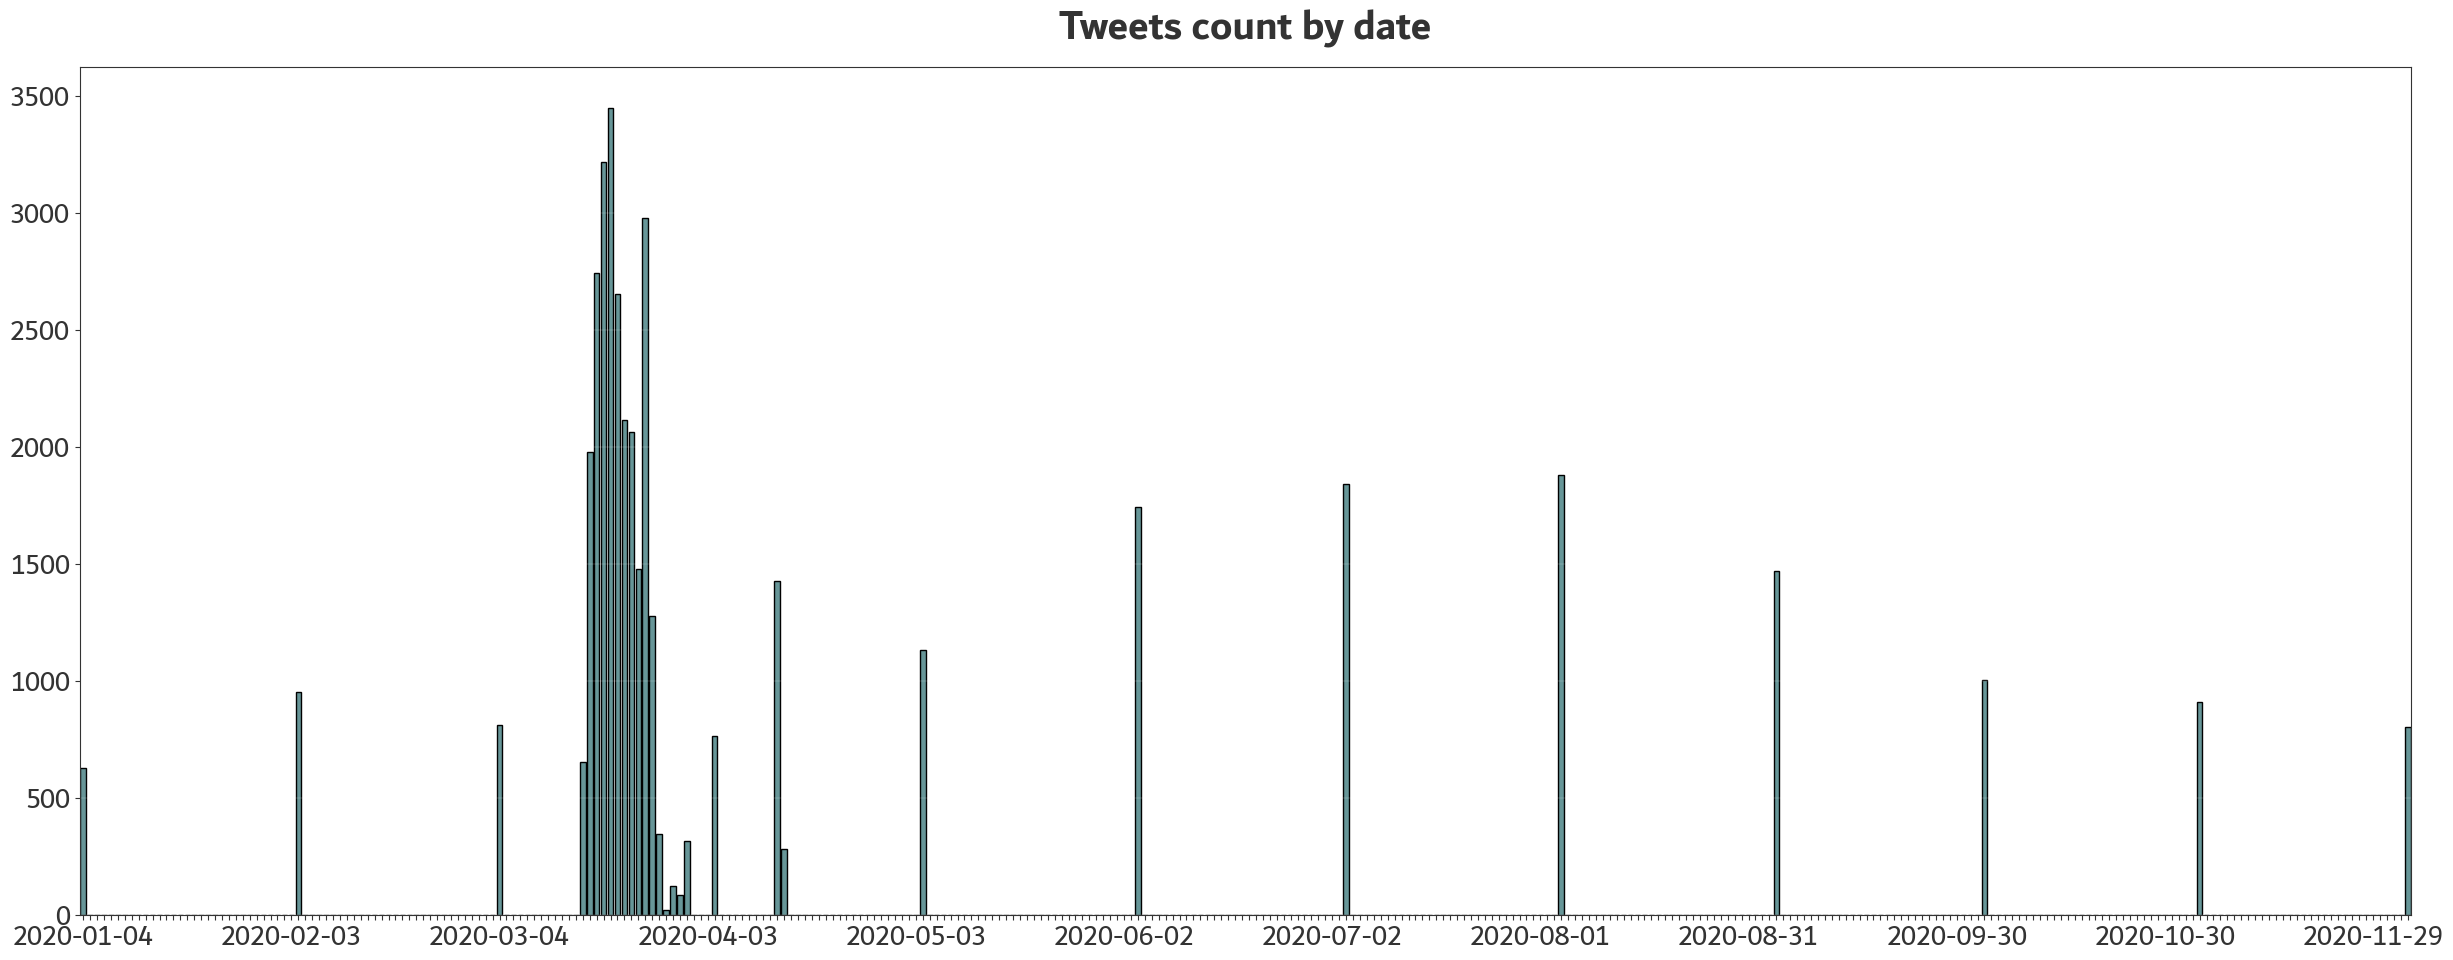

In [26]:
plt.figure(figsize=(25, 10))
ax = sns.barplot(x='Date', y='Tweets', data=tweets_per_day, edgecolor = 'black', color=colors_palette[13])
plt.title('Tweets count by date')
plt.ylabel('')
plt.xlabel('')

# we only want a label for every month
for i, label in enumerate(ax.get_xticklabels()):
    if i % 30 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.tight_layout()
plt.show()

As we can observe, the majority of tweets are concentrated in the months of April and May, with occasional peaks throughout the rest of the year (possibly due to the tweet extraction methods from the platform).

It is noteworthy that the period with the highest frequency of tweets coincides with the onset of the virus's spread, as we have seen previously.

Now let's examine the locations with the highest concentration of tweets. As noted earlier, the location data does not seem very reliable: in addition to having several null values, the city names are inconsistent and often not unique (e.g., 'London' and 'London, UK' both appear).

To address this issue, we have decided to focus exclusively on the country from which users are tweeting.
By filtering for locations with at least 100 associated tweets, we will extract the country using the Geopy library.

A more realistic and accurate approach would have been to observe all countries associated with each location to get a comprehensive overview. However, given the large size of the dataset and the time required to conduct this research with Geopy, we have decided to use this alternative method.


In [27]:
tweets_per_country = tweets_df['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

In [28]:
tweets_per_country.head()

,index,counts
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373


In [29]:
# apply the find_country function to the location column
tweets_per_country['Country'] = tweets_per_country['index'].apply(find_country)
tweets_per_country.loc[tweets_per_country['index'] == 'UK', 'Country'] = 'United Kingdom'
tweets_per_country = tweets_per_country.groupby('Country')['counts'].sum().reset_index()

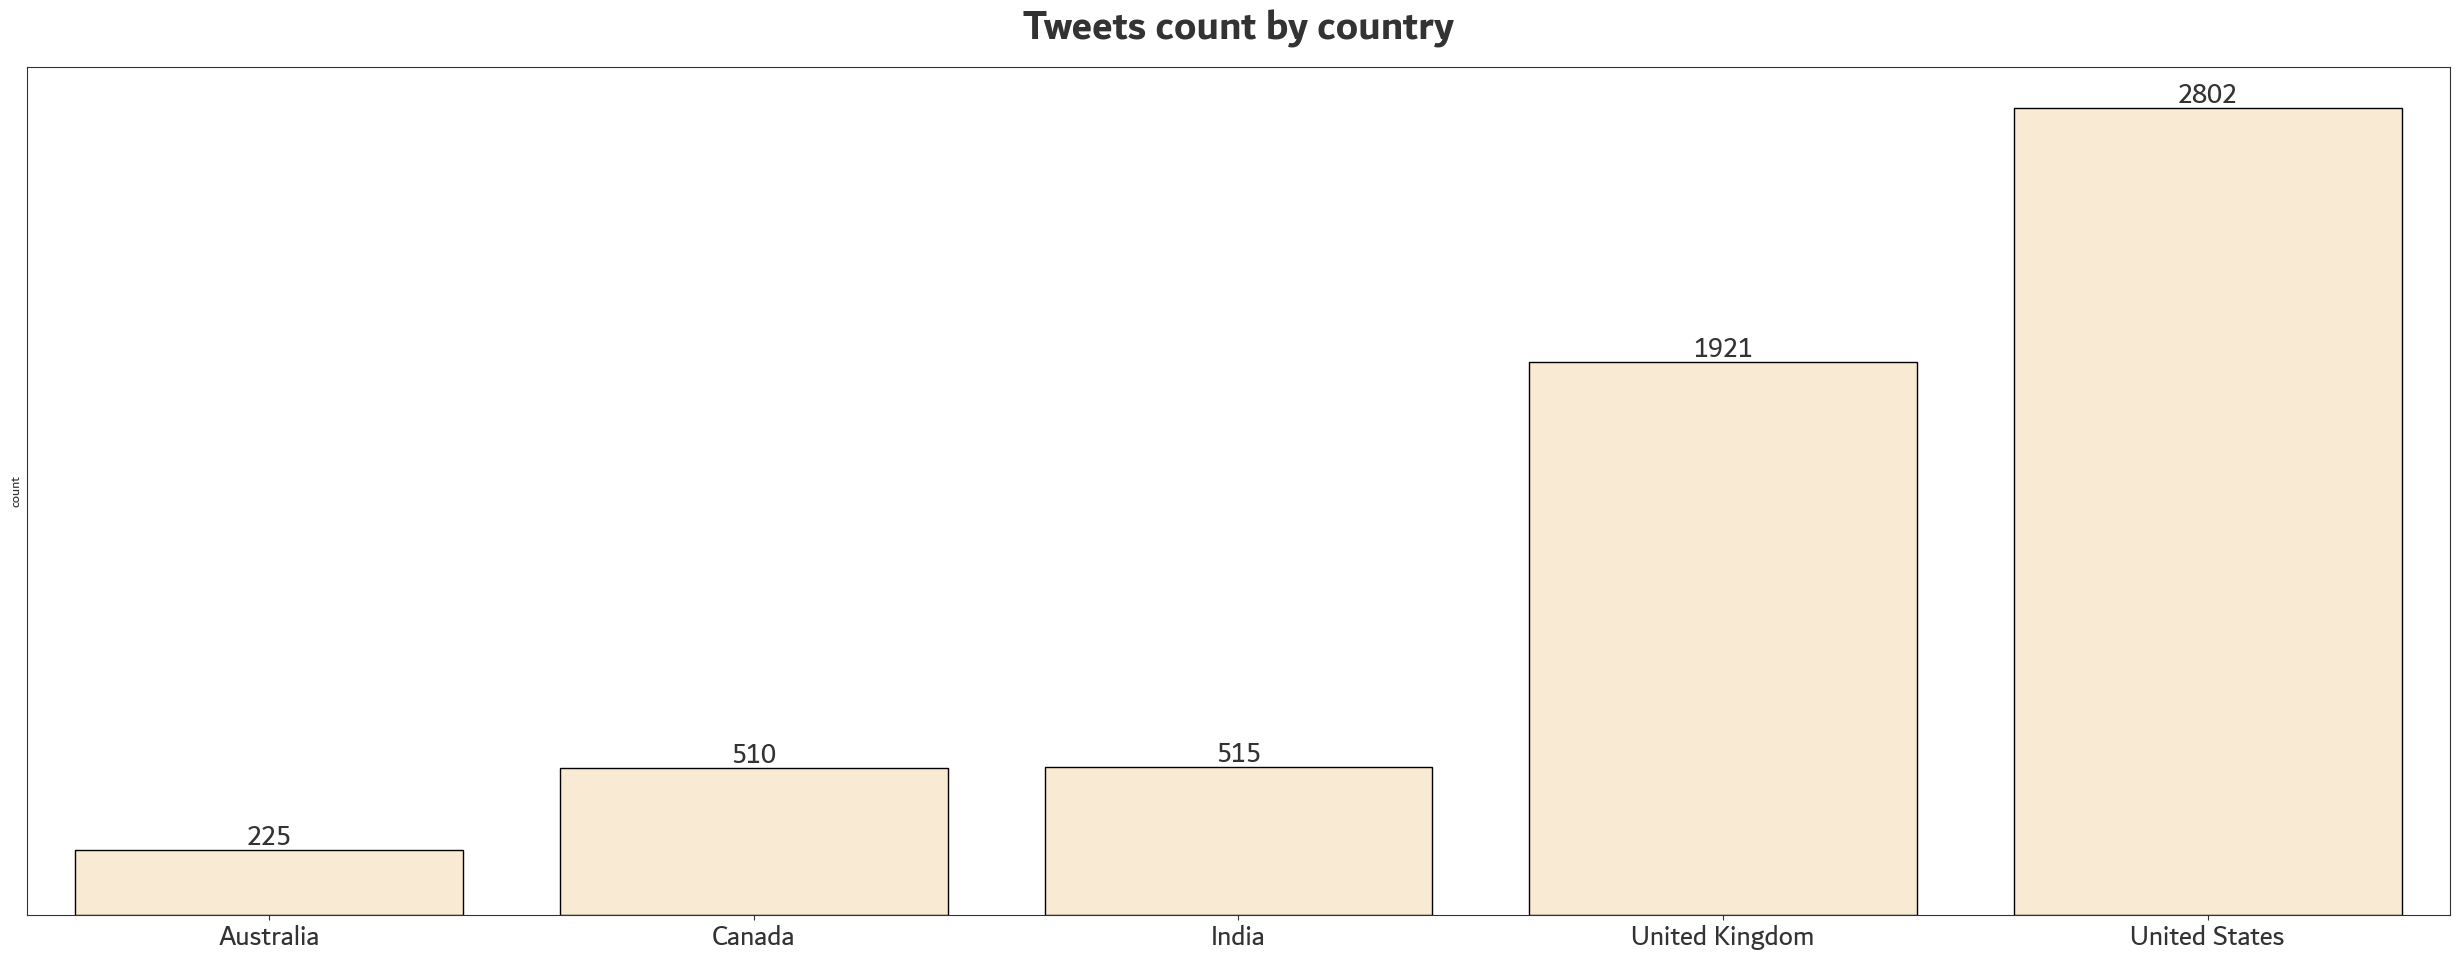

In [30]:
plt.figure(figsize=(25,10))
ax = sns.barplot(x='Country', y='counts', data=tweets_per_country, edgecolor = 'black', color=colors_palette[8])
plt.title('Tweets count by country')
plt.xticks(rotation=0)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')

plt.tight_layout()
plt.show()

Therefore, the countries of the locations with at least 100 associated tweets are:
United States, United Kingdom, India, Canada, and Spain.

Now, let's observe the distribution of sentiments (column "Sentiment" from tweets_df) for these countries.

Special attention should be given to the United States and India, as these countries were among the most affected by the COVID cases, as observed previously.

Once again, we are considering only the locations with at least 100 associated tweets.



In [31]:
# Group by country and sentiment

tweets_per_location_sentiment = tweets_df[['Location','Sentiment']]
tweets_per_location_sentiment['Sentiment'] = tweets_per_location_sentiment['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})
tweets_per_location_sentiment = tweets_per_location_sentiment.groupby(['Location', 'Sentiment']).size().unstack().fillna(0)
tweets_per_location_sentiment = tweets_per_location_sentiment.loc[tweets_per_location_sentiment.sum(axis=1) > 100]

C:\Users\tomma\AppData\Local\Temp\ipykernel_15540\1780997586.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
# substitute location with country
tweets_per_country_sentiment = tweets_per_location_sentiment.reset_index()

# apply the find_country function to the location column
tweets_per_country_sentiment['Country'] = tweets_per_country_sentiment['Location'].apply(find_country)
tweets_per_country_sentiment.loc[tweets_per_country_sentiment['Location'] == 'UK', 'Country'] = 'United Kingdom'
tweets_per_country_sentiment = pd.DataFrame(tweets_per_country_sentiment.groupby('Country').sum())

C:\Users\tomma\AppData\Local\Temp\ipykernel_15540\2503082176.py:7: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



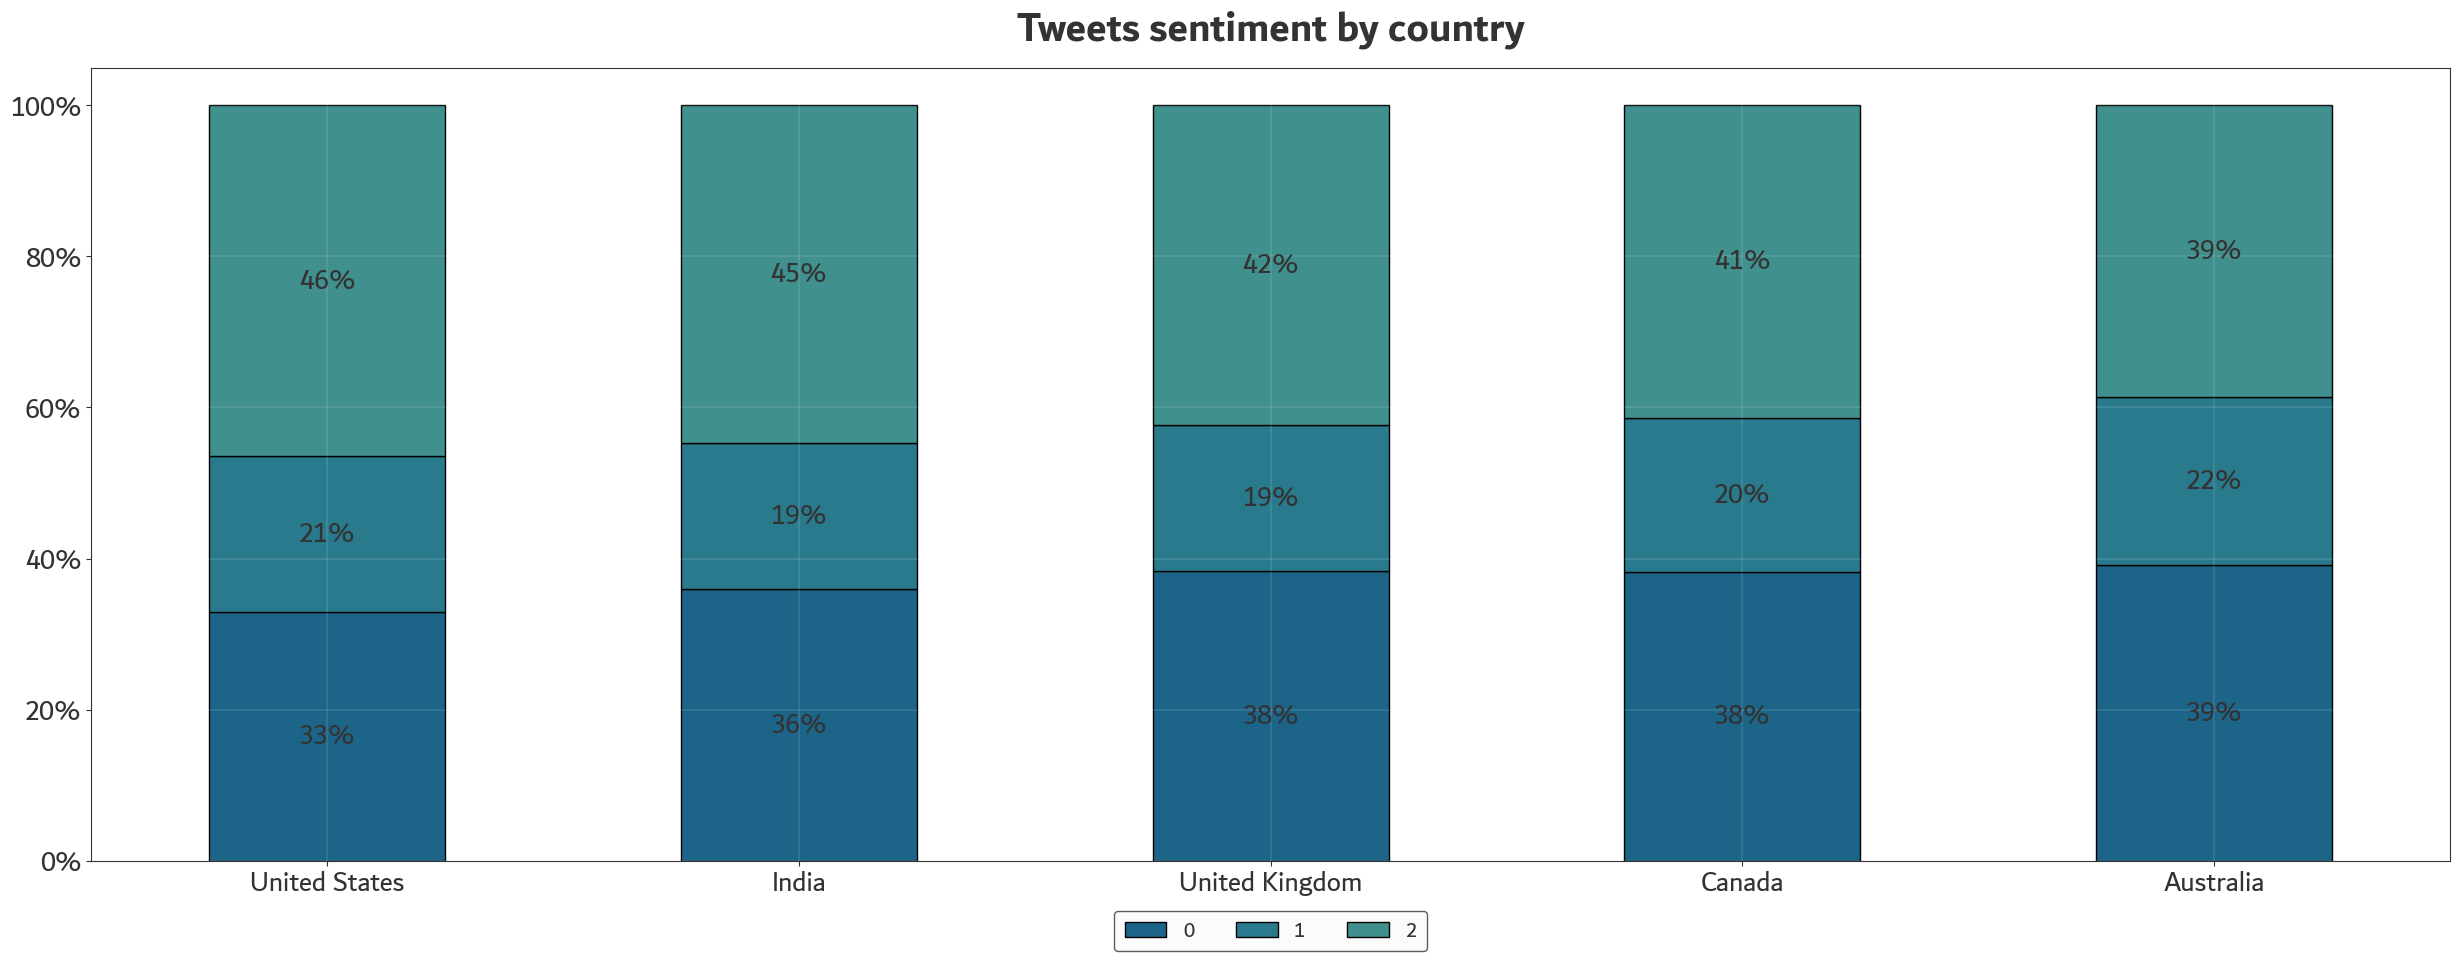

In [33]:
# Normalize the data and sort by positive sentiment
tweets_per_country_sentiment = tweets_per_country_sentiment.div(tweets_per_country_sentiment.sum(axis=1), axis=0).sort_values(by=2, ascending=False)

# Plotting
tweets_per_country_sentiment.plot(kind='bar', stacked=True, figsize=(25, 10), color=sns.color_palette('crest').as_hex()[0:5][::-1], edgecolor = 'black')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.xlabel('')
plt.title('Tweets sentiment by country')

# add percentage labels
for p in plt.gca().patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    plt.gca().annotate(f'{height:.0%}', (x + width/2, y + height/2), ha='center', va='center')

plt.tight_layout()

As previously noted, this analysis is based on a subset of the tweets, so we should be cautious about drawing definitive conclusions from the above graph. 

However, an interesting observation can be made: despite the US and India experiencing significantly tougher periods compared to other countries during the pandemic, there appears to be a higher rate of enthusiasm and hope (positive sentiments) in these tweets.

This might reflect the resilience and optimism of the people in these countries. It's important to consider that these results might be influenced by various factors, such as differences in population size, Twitter usage rates, and cultural expressions of emotion.